In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

In [7]:
df = pd.read_csv("../data/clean_data.csv", sep=",", index_col=0)

df.head()

,id,title,area,interpretability,doi,source,working_doi,abstract,embedding,classifier_interpretability_prediction
0,main.8,Large Scale Multi-Actor Generative Dialog Mode...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.8,ACL2020,True,Non-goal oriented dialog agents (i.e. chatbots...,[-5.58118939e-01 -1.25368834e-01 -6.33979887e-...,False
1,main.52,CDL: Curriculum Dual Learning for Emotion-Cont...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.52,ACL2020,True,Emotion-controllable response generation is an...,[-1.12784958e+00 -5.22979379e-01 5.63119724e-...,False
2,main.46,Emergence of Syntax Needs Minimal Supervision,Theory and Formalism in NLP (Linguistic and Ma...,False,10.18653/v1/2020.acl-main.46,ACL2020,True,This paper is a theoretical contribution to th...,[ 2.61768043e-01 8.10616314e-01 2.74266422e-...,False
3,main.359,Selecting Backtranslated Data from Multiple So...,Machine Translation,False,10.18653/v1/2020.acl-main.359,ACL2020,True,Machine translation (MT) has benefited from us...,[-4.39277172e-01 1.06740630e+00 8.58952925e-...,False
4,main.417,ParaCrawl: Web-Scale Acquisition of Parallel C...,Resources and Evaluation,False,10.18653/v1/2020.acl-main.417,ACL2020,True,We report on methods to create the largest pub...,[-3.59388590e-01 3.36527884e-01 -2.65376344e-...,False


In [10]:
df['is_mt'] = df['area'].str.lower().str.contains('translation')
df.head()

,id,title,area,interpretability,doi,source,working_doi,abstract,embedding,classifier_interpretability_prediction,is_mt
0,main.8,Large Scale Multi-Actor Generative Dialog Mode...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.8,ACL2020,True,Non-goal oriented dialog agents (i.e. chatbots...,[-5.58118939e-01 -1.25368834e-01 -6.33979887e-...,False,False
1,main.52,CDL: Curriculum Dual Learning for Emotion-Cont...,Dialogue and Interactive Systems,False,10.18653/v1/2020.acl-main.52,ACL2020,True,Emotion-controllable response generation is an...,[-1.12784958e+00 -5.22979379e-01 5.63119724e-...,False,False
2,main.46,Emergence of Syntax Needs Minimal Supervision,Theory and Formalism in NLP (Linguistic and Ma...,False,10.18653/v1/2020.acl-main.46,ACL2020,True,This paper is a theoretical contribution to th...,[ 2.61768043e-01 8.10616314e-01 2.74266422e-...,False,False
3,main.359,Selecting Backtranslated Data from Multiple So...,Machine Translation,False,10.18653/v1/2020.acl-main.359,ACL2020,True,Machine translation (MT) has benefited from us...,[-4.39277172e-01 1.06740630e+00 8.58952925e-...,False,True
4,main.417,ParaCrawl: Web-Scale Acquisition of Parallel C...,Resources and Evaluation,False,10.18653/v1/2020.acl-main.417,ACL2020,True,We report on methods to create the largest pub...,[-3.59388590e-01 3.36527884e-01 -2.65376344e-...,False,False


In [13]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch

SEED = 2024
SPLIT = 0.2

X = np.stack(df['embedding'].values)
X = torch.stack([torch.tensor(np.fromstring(x[1:-1], sep='\n'), dtype=torch.float32) for x in X])

y = df['is_mt'].values
y = torch.tensor([1 if label else 0 for label in y], dtype=torch.long)

indices = np.arange(len(df))
train_indices, test_indices = train_test_split(indices, test_size=SPLIT, random_state=SEED)

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

df_train, df_test = df.iloc[train_indices], df.iloc[test_indices]

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim


class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.softmax(out, dim=-1)
        return out


In [15]:
HIDDEN_SIZE = 400 
BATCH_SIZE = 150
LR = 0.002
INPUT_SIZE = X_train.shape[1]

In [17]:
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch

train_dataset = TensorDataset(X_train, y_train)

class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.67it/s]


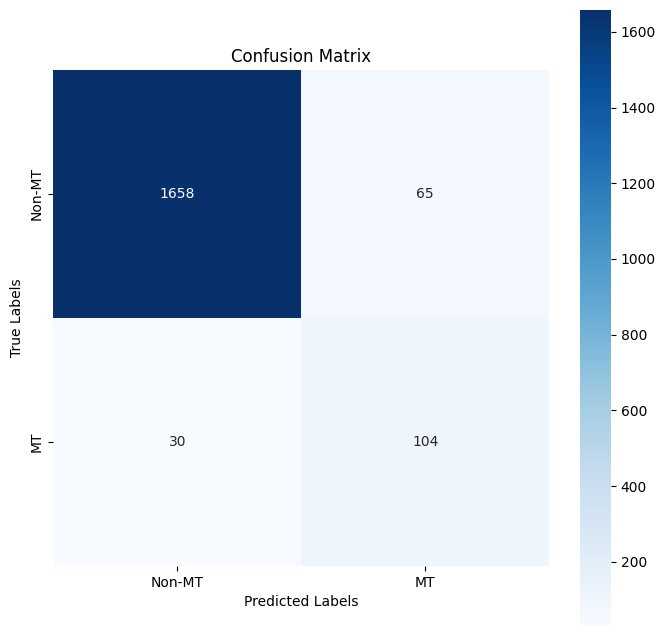

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

model = MLPClassifier(INPUT_SIZE, HIDDEN_SIZE, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
EPOCHS = 100

for epoch in tqdm(range(EPOCHS)):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float(), labels.float()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', square=True)
labels = ['Non-MT', 'MT']
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_title('Confusion Matrix')
plt.show()


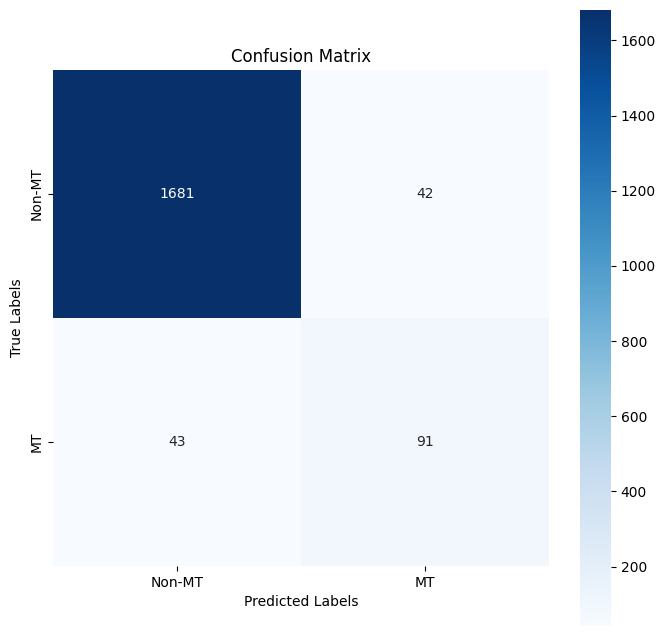

In [23]:
KEYWORDS = ['translation']

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for index, row in df_test.iterrows():
        x = row['embedding']
        vector = torch.tensor(np.fromstring(x[1:-1], sep='\n'), dtype=torch.float32)
        output = model(vector)
        pred = torch.argmax(output)
        has_keyword = any([word in row['abstract'].lower() for word in KEYWORDS])
        y_pred.append((pred and has_keyword))
        y_true.append(int(row['is_mt']))

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', square=True)
labels = ['Non-MT', 'MT']
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_title('Confusion Matrix')
plt.show()

In [25]:
model.eval()
with torch.no_grad():
    for index, row in df_test.iterrows():
        x = row['embedding']
        vector = torch.tensor(np.fromstring(x[1:-1], sep='\n'), dtype=torch.float32)
        output = model(vector)
        pred = torch.argmax(output)
        has_keyword = any([word in row['abstract'].lower() for word in KEYWORDS])

        if (pred and has_keyword) and not row['is_mt']:
            print(row['title'])
            print(row['abstract'])
            print()
            print('Correct: ')
            print('-' * 20 + '\n')

UnitY: Two-pass Direct Speech-to-speech Translation with Discrete Units
Direct speech-to-speech translation (S2ST), in which all components can be optimized jointly, is advantageous over cascaded approaches to achieve fast inference with a simplified pipeline. We present a novel two-pass direct S2ST architecture, UnitY, which first generates textual representations and predicts discrete acoustic units subsequently. We enhance the model performance by subword prediction in the first-pass decoder, advanced two-pass decoder architecture design and search strategy, and better training regularization. To leverage large amounts of unlabeled text data, we pre-train the first-pass text decoder based on the self-supervised denoising auto-encoding task. Experimental evaluations on benchmark datasets at various data scales demonstrate that UnitY outperforms a single-pass speech-to-unit translation model by 2.5-4.2 ASR-BLEU with 2.83x decoding speed-up. We show that the proposed methods boost the 

In [27]:
torch.save(model.state_dict(), './mt-classifier-weights.pt')